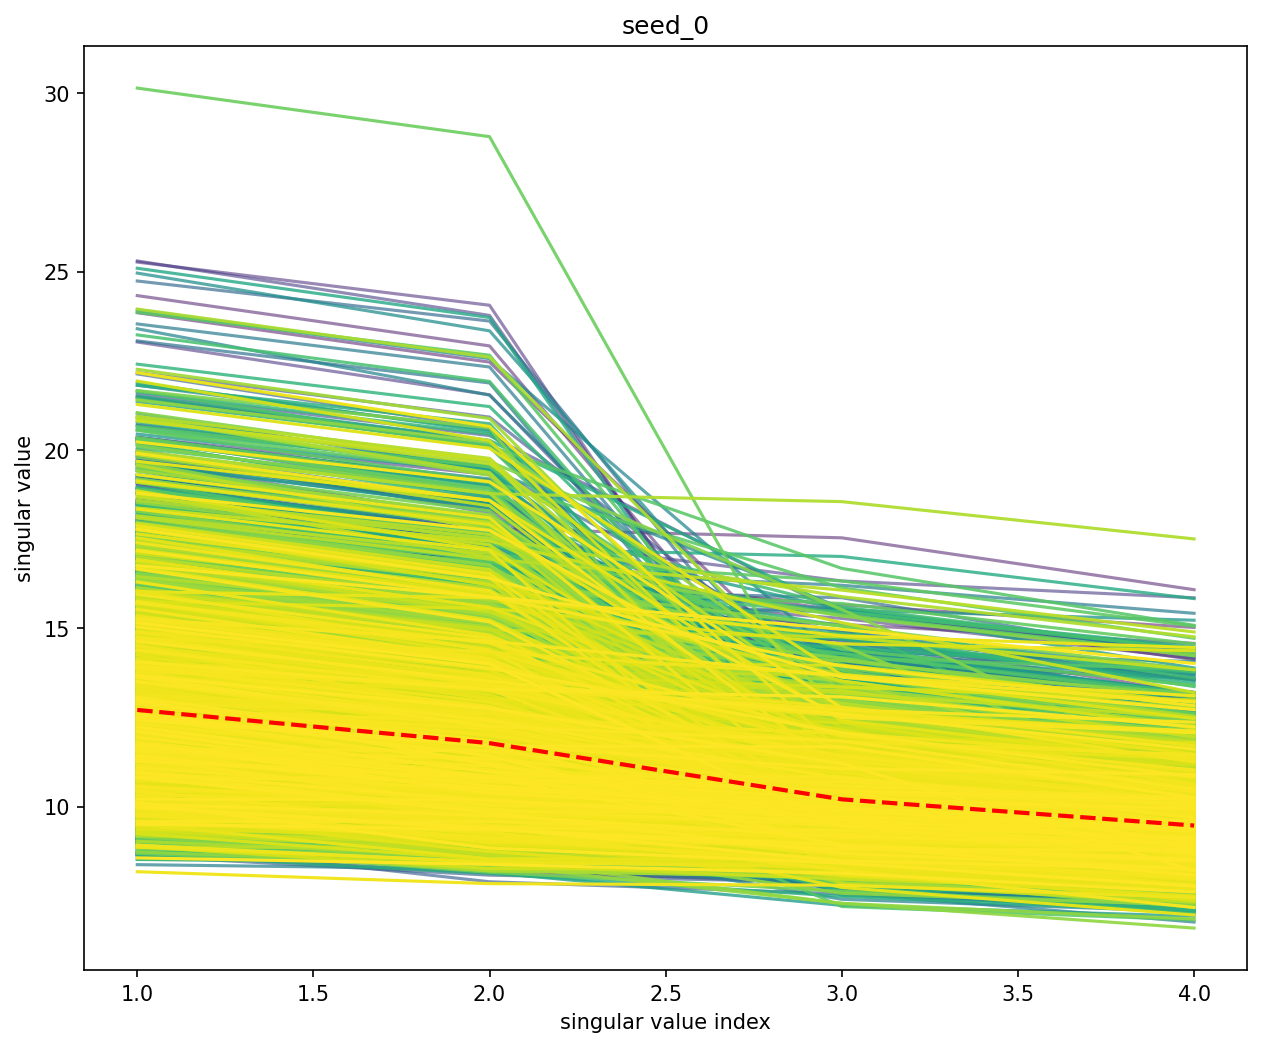

In [4]:
from svd_tool import plot_singular
from svd_tool import plot_ce_index
from svd_tool import analysis_u
from svd_tool import macro_analysis
from svd_tool import micro_analysis_jac
from svd_tool import micro_analysis_ig
from svd_tool import save_macro
from svd_tool import save_cg
from svd_tool import set_up
import torch
import numpy as np
import matplotlib.pyplot as plt

setting = 'long_term_forecast_for_macro_dyn_NN_SIR_samp1000_sigma0.01_rho-0.5_dm128_layer1_'
start = 1
end = 6000
interval = 1
seq_len = 1
singular, us, vts, mats, Sigs = plot_singular(setting, seed = 1, start=start, end=end, interval=interval, log_bool=True)


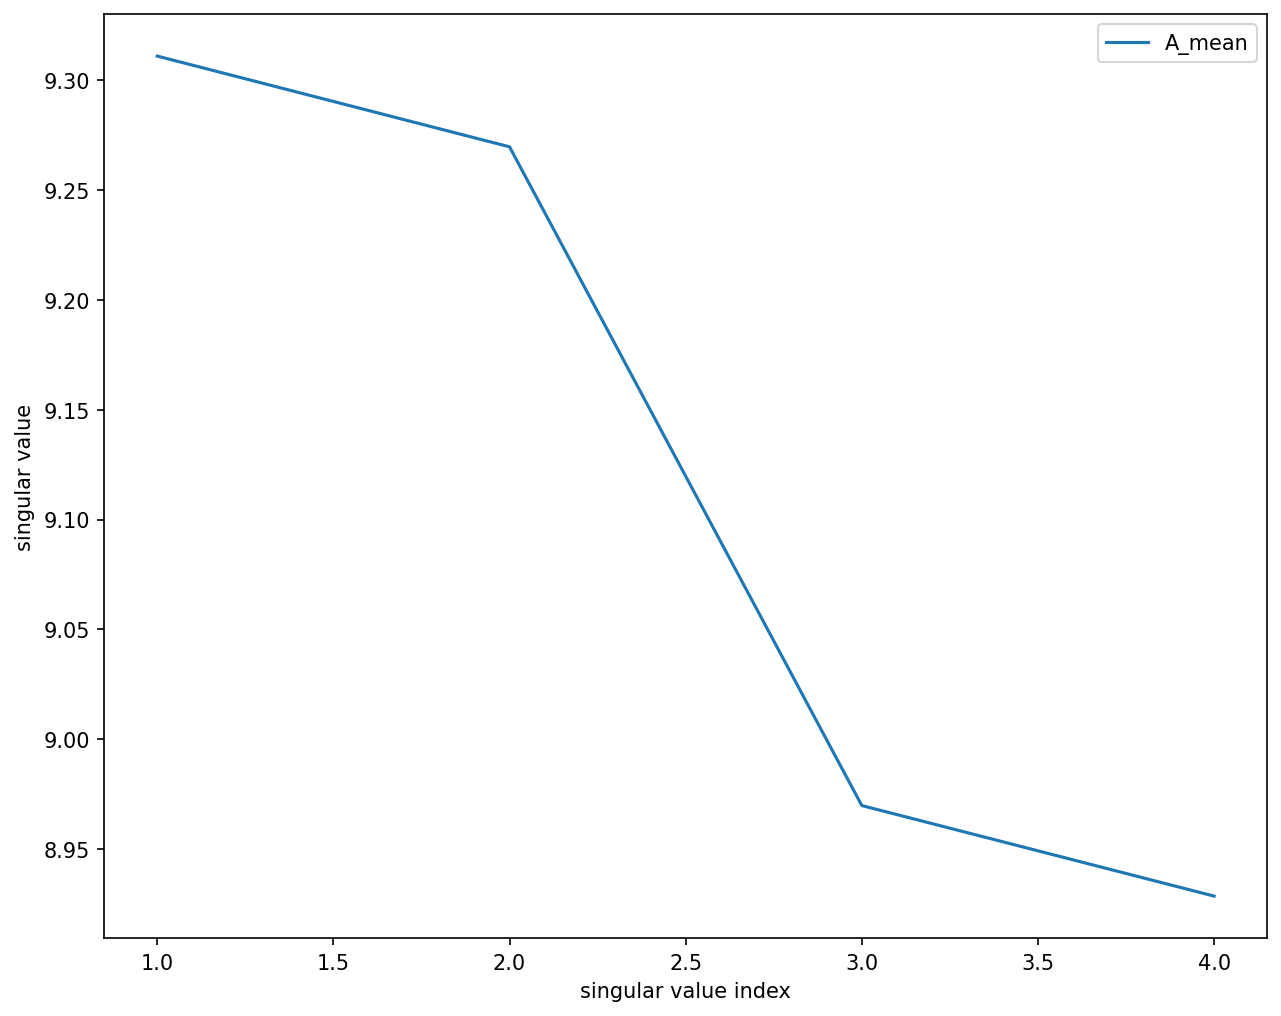

In [5]:
from svd_tool import svd_jacs
from svd_tool import cal_W

def plot_singular2(test_id_first, micro_dims=4, seed = 0, start=1, end=1000, interval=1, abs_bool=False):
    singular, us, vts, mats, Sigs = svd_jacs(test_id_first, start, end, interval, seed, abs_bool)
    num_lines = (end - start) // interval + 1
    plt.figure(figsize=(10,8),dpi=150)
    jac_arrs = np.zeros([num_lines, micro_dims, micro_dims])
    sig_arrs = np.zeros([num_lines, micro_dims, micro_dims])
    for idx, i in enumerate(range(start, end, interval)):
        jac_arrs[idx,:, :] = np.array(mats[i][0])
        sig_arrs[idx,:, :] = np.array(Sigs[i][0])
    jac_mean = np.mean(jac_arrs, axis=0)
    sigma_mean = np.mean(sig_arrs, axis=0)
    U2U, S2, V2T = cal_W(jac_mean, sigma_mean, abs_bool=False)
    S_log = np.log(S2)

    plt.plot([j+1 for j in range(len(S_log))], S_log , label=f'A_mean')

    plt.xlabel('singular value index')
    plt.ylabel('singular value')
    plt.legend()
    plt.show()

    return singular, us, vts, mats, Sigs

setting = 'long_term_forecast_for_macro_dyn_NN_SIR_samp1000_sigma0.01_rho-0.5_dm128_layer1_'
start = 1
end = 6000
interval = 1
seq_len = 1
singular, us, vts, mats, Sigs = plot_singular2(setting, seed = 1, start=start, end=end, interval=interval)


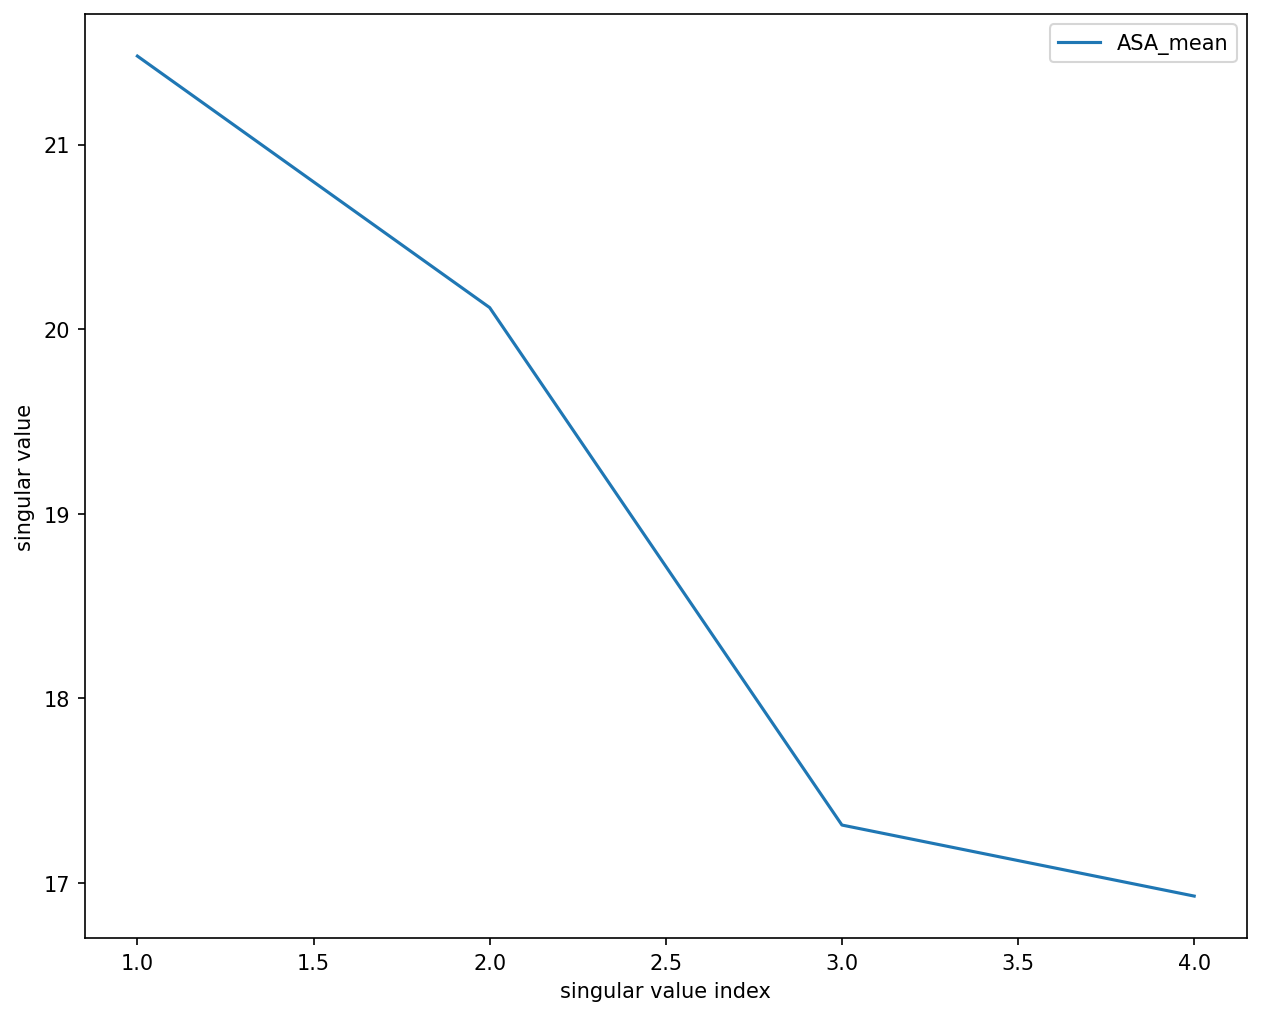

In [6]:
from svd_tool import svd_jacs
from svd_tool import cal_W
from svd_tool import create_block_diagonal_matrix

def cal_W_mean(matrix_a, matrix_b, abs_bool=False):
    n = mats[1][0].shape[0]
    block_matrix = create_block_diagonal_matrix(matrix_a, matrix_b)
    U, S, VT = np.linalg.svd(block_matrix)
    
    U2 = U[:n,:] + U[n:,:]
    U2 = U2 @ np.diag(S)
    U2U, S2, V2T = np.linalg.svd(U2)
    if abs_bool:
        U2U = np.abs(U2U)
    return U2U, S2, V2T

def plot_singular3(test_id_first, micro_dims=4, seed = 0, start=1, end=1000, interval=1, abs_bool=False):
    singular, us, vts, mats, Sigs = svd_jacs(test_id_first, start, end, interval, seed, abs_bool)
    num_lines = (end - start) // interval + 1
    plt.figure(figsize=(10,8),dpi=150)
    ma_arrs = np.zeros([num_lines, micro_dims, micro_dims])
    mb_arrs = np.zeros([num_lines, micro_dims, micro_dims])
    for idx, i in enumerate(range(start, end, interval)):
        Sigma_pinv = np.linalg.inv(Sigs[i][0]) #np.linalg.pinv(Sigma, rcond=1e-15)
        matrix_a = np.conj(mats[i][0]).T @ Sigma_pinv @ mats[i][0]
        matrix_b = Sigma_pinv
        ma_arrs[idx,:, :] = matrix_a
        mb_arrs[idx,:, :] = matrix_b
    ma_mean = np.mean(ma_arrs, axis=0)
    mb_mean = np.mean(mb_arrs, axis=0)
    U2U, S2, V2T = cal_W_mean(ma_mean, mb_mean, abs_bool=False)
    S_log = np.log(S2)

    plt.plot([j+1 for j in range(len(S_log))], S_log , label=f'ASA_mean')

    plt.xlabel('singular value index')
    plt.ylabel('singular value')
    plt.legend()
    plt.show()

    return singular, us, vts, mats, Sigs

setting = 'long_term_forecast_for_macro_dyn_NN_SIR_samp1000_sigma0.01_rho-0.5_dm128_layer1_'
start = 1
end = 6000
interval = 1
seq_len = 1
singular, us, vts, mats, Sigs = plot_singular3(setting, seed = 1, start=start, end=end, interval=interval)


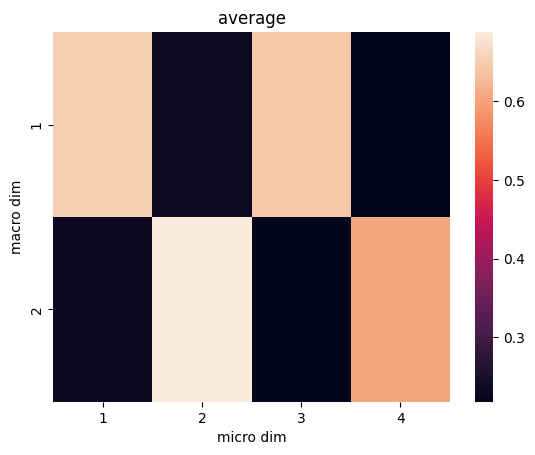

In [2]:
micro_dims = 4
macro_dims = 2
cg_mat_abs = analysis_u(us, micro_dims, start, end, interval, macro_dim=macro_dims, seq_len=1, abs_bool=True, mean_bool=True, show_bool=False)

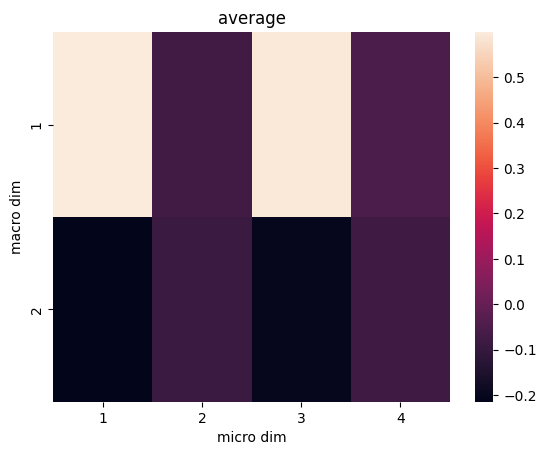

In [3]:
micro_dims = 4
macro_dims = 2
cg_mat = analysis_u(us, micro_dims, start, end, interval, macro_dim=macro_dims, seq_len=1, abs_bool=False, mean_bool=True, show_bool=False)

In [4]:
micro_path ="../dataset/SIR/train_7000_0.01.npy"
macro_path = f"../dataset/SIR/macro_{macro_dims}.npy"
save_macro(cg_mat, macro_dims, micro_path, macro_path, one_serie=False)

In [5]:
micro_path ="../dataset/SIR/train_7000_0.01.npy"
macro_path = f"../dataset/SIR/SIR_{micro_dims}_to_{macro_dims}"
save_cg(cg_mat, micro_dims, macro_dims, micro_path, macro_path, one_serie=False)

In [33]:
initial_value = np.array([0.5,0.5])
def multi_step_predict(model, initial_value, steps_to_predict):
    model.eval()
    model_dtype = next(model.parameters()).dtype
    current_value = initial_value
    current_value = np.expand_dims(current_value, axis=0) # 增加一个维度，变成 (1, sequence_length, feature_dimension)
    current_value = np.expand_dims(current_value, axis=0)
    predictions = [current_value]
    current_value = torch.tensor(current_value, dtype=model_dtype)
    for _ in range(steps_to_predict):
        # 预测下一步
        predicted_value = model(current_value)[0]
        predictions.append(predicted_value.detach().numpy())
        current_value = predicted_value
    return np.array(predictions)
seqs = multi_step_predict(model, initial_value, 40)

In [34]:
def simulate_oneserie(S, I, steps=100, beta=1, gamma=0.5, dt=0.01):
        """
        Simulate a single time series from a specific starting point.
        
        :param S: Initial susceptible population (as a ratio).
        :param I: Initial infected population (as a ratio).
        :return: Time series data.
        """
        sir_data = [[S, I]]
        for k in range(steps):
                
            new_infected = beta * S * I 
            new_recovered = gamma * I
            S = S - new_infected * dt
            I = I + (new_infected - new_recovered) * dt
            sir_data.append([S, I])
        return np.array(sir_data)
    
sir_data = simulate_oneserie(S=0.5, I=0.5, steps=100, beta=1, gamma=0.5, dt=0.01)
sir_data.shape

(101, 2)

模型所在的设备：cpu


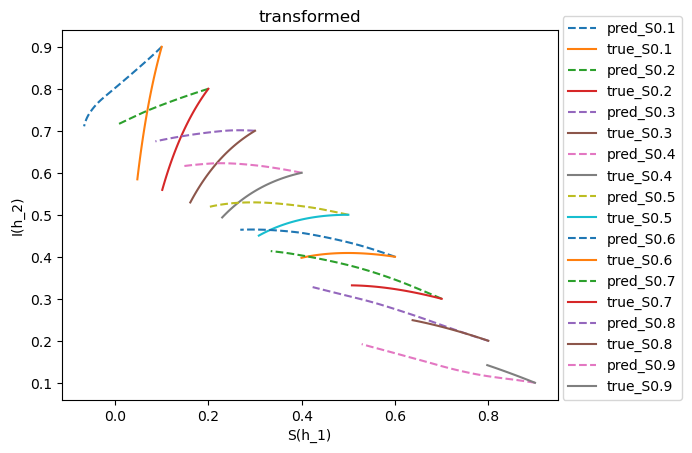

In [43]:
def symmetric_transform(x, y):
    """
    关于直线 y = 1 - x 对称变换坐标 (x, y).

    :param x: 原始点的 x 坐标.
    :param y: 原始点的 y 坐标.
    :return: 变换后的点的 x 和 y 坐标 (x_new, y_new).
    """
    x_new = 1 - y
    y_new = 1 - x
    return x_new, y_new

setting = 'long_term_forecast_check_macro_cgfree_NN_SIR_samp9000_sigma0.03_rho-0.5_dm128_layer1_'
model = set_up(setting+'0')
device = next(model.parameters()).device
print(f"模型所在的设备：{device}")

plt.figure()
for S in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:
    I = 1 - S
    initial_value = np.array([S,I])
    seqs = multi_step_predict(model, initial_value, 100)
    seq_x, seq_y = symmetric_transform(seqs[:,0,0,0], seqs[:,0,0,1])
    sir_data = simulate_oneserie(S=S, I=I, steps=100, beta=1, gamma=0.5, dt=0.01)
    plt.plot(seq_x, seq_y, label=f'pred_S{S}', linestyle='--')
    plt.plot(sir_data[:,0], sir_data[:,1], label=f'true_S{S}')
plt.legend(loc=[1.01,0])
plt.xlabel('S(h_1)')
plt.ylabel('I(h_2)')
plt.title('transformed')
plt.show()

模型所在的设备：cpu


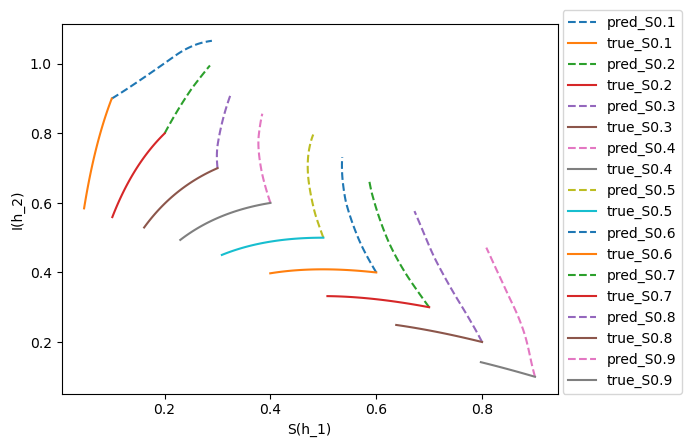

In [41]:
setting = 'long_term_forecast_check_macro_cgfree_NN_SIR_samp9000_sigma0.03_rho-0.5_dm128_layer1_'
model = set_up(setting+'0')
device = next(model.parameters()).device
print(f"模型所在的设备：{device}")

plt.figure()
for S in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:
    I = 1 - S
    initial_value = np.array([S,I])
    seqs = multi_step_predict(model, initial_value, 100)
    sir_data = simulate_oneserie(S=S, I=I, steps=100, beta=1, gamma=0.5, dt=0.01)
    plt.plot(seqs[:,0,0,0], seqs[:,0,0,1], label=f'pred_S{S}', linestyle='--')
    plt.plot(sir_data[:,0], sir_data[:,1], label=f'true_S{S}')
plt.legend(loc=[1.01,0])
plt.xlabel('S(h_1)')
plt.ylabel('I(h_2)')
plt.show()

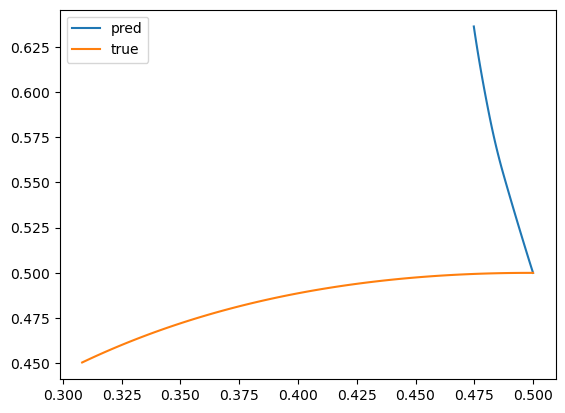

In [35]:
plt.figure()
plt.plot(seqs[:,0,0,0], seqs[:,0,0,1], label='pred')
plt.plot(sir_data[:,0], sir_data[:,1], label='true')
plt.legend()
plt.show()

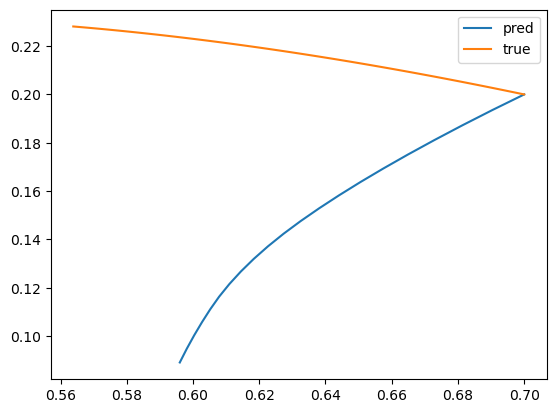

In [21]:
plt.figure()
plt.plot(seqs[:,0,0,0], seqs[:,0,0,1], label='pred')
plt.plot(sir_data[:,0], sir_data[:,1], label='true')
plt.legend()
plt.show()

模型所在的设备：cpu


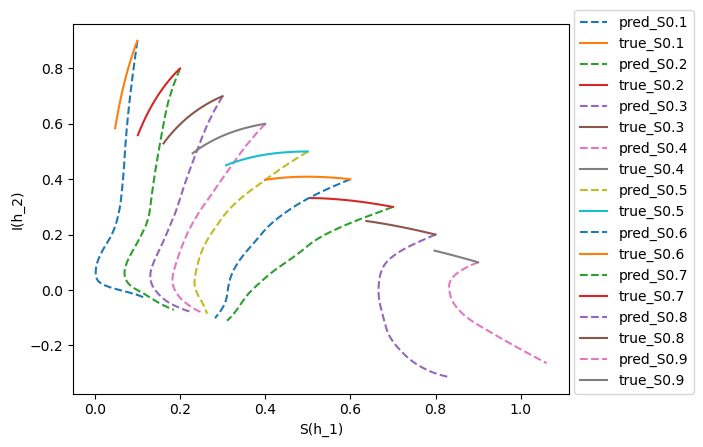

In [39]:
setting = 'long_term_forecast_check_macro_NN_SIR_samp9000_sigma0.03_rho-0.5_dm128_layer1_'
model = set_up(setting+'0')
device = next(model.parameters()).device
print(f"模型所在的设备：{device}")

plt.figure()
for S in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:
    I = 1 - S
    initial_value = np.array([S,I])
    seqs = multi_step_predict(model, initial_value, 100)
    sir_data = simulate_oneserie(S=S, I=I, steps=100, beta=1, gamma=0.5, dt=0.01)
    plt.plot(seqs[:,0,0,0], seqs[:,0,0,1], label=f'pred_S{S}', linestyle='--')
    plt.plot(sir_data[:,0], sir_data[:,1], label=f'true_S{S}')
plt.legend(loc=[1.01,0])
plt.xlabel('S(h_1)')
plt.ylabel('I(h_2)')
plt.show()

In [ ]:
def plot_singular2(test_id_first, seed = 0, start=1, end=1000, interval=1, abs_bool=False, leg_show=False, mean_curve=True, diff=False):
    singular, us, vts, mats, Sigs = svd_jacs(test_id_first, start, end, interval, seed, abs_bool)
    num_lines = (end - start) // interval + 1
    for k in range(seed):
        plt.figure(figsize=(10,8),dpi=150)
        all_curves = []
        for idx, i in enumerate(range(start, end, interval)):
            jac_arr = np.array(singular[i][k])

            window = len(jac_arr)
            
            if diff:
                diff_curve = [jac_arr[d]-jac_arr[d+1] for d in range(window-1)]
                diff_curve.append(0)
                jac_arr = diff_curve

            jac_arr = np.log(jac_arr)
            
            # 归一化 idx 到0-1区间，做为colormap的输入
            color_val = idx / (num_lines - 1)
            color = cmap(color_val)
            alpha = 0.5 + 0.5 * color_val

            plt.plot([j+1 for j in range(window)],jac_arr[:window], label=f'time_{i}', color=color, alpha=alpha)
            all_curves.append(jac_arr[:window])
            
       
            
        plt.title(f'seed_{k}')
        plt.xlabel('singular value index')
        plt.ylabel('singular value')
        if leg_show:
            plt.legend()
        plt.show()

    return singular, us, vts, mats, Sigs